# Notebook follows the implementation in [this tutorial](https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2d-2class-dataset/2d-2class-dataset.csv


# Load the dataset

A 2D dataset has been created using [this tool](http://notmatthancock.github.io/software/dataset2d/)

<AxesSubplot:xlabel='x', ylabel='y'>

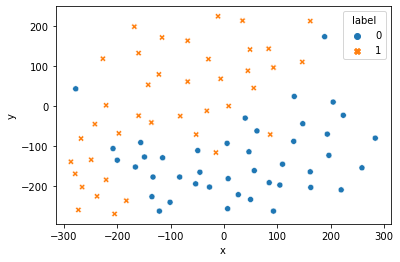

In [2]:
df = pd.read_csv("/kaggle/input/2d-2class-dataset/2d-2class-dataset.csv", )
df.columns = ['x', 'y', 'label']
sns.scatterplot(data=df, x='x', y='y', style='label', hue='label')

# Reshape the input and output data to the proper size
* `input = [2xN]`
*`output = [1xN]`

where `N` is the number of labeled samples.

In [3]:
input_array = df[['x','y']].to_numpy().T
output_array = np.expand_dims(df['label'].to_numpy(), axis=0)
print(f"input array shape: {input_array.shape}")
print(f"output array shape: {output_array.shape}")

input array shape: (2, 82)
output array shape: (1, 82)


# Define the architecture
Check that `output_dim` of each layer matches the `input_dim` of the next layer.

In [4]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

def validate_architecture(nn_architecture):
    output_dim = None
    for idx, layer in enumerate(nn_architecture):
        if (output_dim != None) and (layer["input_dim"]!=output_dim):
            return f"Output_dim of {idx-1} layer ({output_dim}) does not match input_dim of {idx} layer ({layer['input_dim']})"
        output_dim = layer["output_dim"]
    return ""

assert validate_architecture(nn_architecture) == "", validate_architecture(nn_architecture)

# Initialize layer parameters
## The parameters are initialized <u>randomly</u> with a value <u>close to 0</u>

In [5]:
def init_layers(nn_architecture, seed=99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values={}
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1
        
    return params_values

params_values = init_layers(nn_architecture, seed=99)

In [6]:
# Display the dimension of parameters in each layer.

def display_params_dims(params):
    layers = [[None, None] for i in range(len(params)//2)]
    for k, v in params.items():
        layer_number = int(k[1:])
        param_type = k[0]
        if param_type == 'W':
            layers[layer_number-1][0] = v.shape
        if param_type == 'b':
            layers[layer_number-1][1] = v.shape
    
    for idx, layer in enumerate(layers):
        print(f"W{idx+1}: {layer[0]}  ,  b{idx+1}: {layer[1]}")
        
display_params_dims(params_values)

W1: (4, 2)  ,  b1: (4, 1)
W2: (6, 4)  ,  b2: (6, 1)
W3: (6, 6)  ,  b3: (6, 1)
W4: (4, 6)  ,  b4: (4, 1)
W5: (1, 4)  ,  b5: (1, 1)


# Define the activation functions and their derivatives
The derivatives are needed for the backpropagation step.

In [7]:
def sigmoid(Z):
    sig = 1/(1+np.exp(-Z))
    sig = np.minimum(sig, 0.9999)  # Set upper bound
    sig = np.maximum(sig, 0.0001)  # Set lower bound
    return sig

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    '''
    dA: array-like
        Gradient of the activation function from the next layer (closer to the output).
        Note that when dowing the backward propagation we use the gradient of layers
        closer to the output to calculate the gradient of the layers 
        the earlier layers closer to the input.
    '''
    sig = sigmoid(Z)
    return dA * sig * (1-sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

# Forward propagation

## First implement a function for forward propagation through a single layer
We return both activation function results $A$ and the intermediate value $Z$ which is needed for the backpropagation step.

In [8]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    '''
    Single layer forward propagation
    
    Parameters:
    -----------
    A_prev: np.array, [N_prev,1]
        output of the previous layer which is input to the current layer
    W_curr: np.array, [N_curr, N_prev]
        The weights for the current layer
    b_curr: np.array, [N_curr, 1]
        The biases for the current layer
    activation: str
        The type of the activation function
    
    Returns:
    --------
    Tuple of length 2: (activation_func(Z_curr), Z_curr)
    '''
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

## Perform a forward propagation through the whole network

In [9]:
def full_forward_propagation(X, params_values, nn_architecture):
    '''
    
    Parameters:
    -----------
    X : array-like, [N, M]
        The input values to the neural network.
        N is the number of features in each sample point.
        M is the number of sample points in the training set.
    params_value: dictionary
        Dictionary the parameters in the following form
        `{'W1': ..., 'b1': ..., 'W2': ..., etc.}`
    nn_architecture: list-like
        List of neural network architecture in the following form.
        It is used to identify the type of the activation function in each layer
        `[{"input_dim": 2, "output_dim": 4, "activation": "relu"}, ...]`
    
    Returns:
    --------
    (A_curr, memory):
        `A_curr` is the activation output from the last layer.
        `memory` is the dictionary of the activation outputs and intermediate
        Z vlaues for each layer in the following form
        `{'A1': ..., 'Z1': ..., 'A2': ..., etc}`
        
    '''
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

In [10]:
# Run the forward network through the training dataset once to make sure that the mechanics are working correctly.
A_curr, memory = full_forward_propagation(input_array, params_values, nn_architecture)

# Define the loss function
Use binary cross-entropy as the loss function for the classification problem

$$
J(W,b) = \frac{1}{m} \sum_{i=1}^{m} L\left(\hat{y}^{(i)},y^{(i}\right)
$$

$$
L\left(\hat{y}^{(i)},y^{(i}\right) = -\left(y \log \hat{y} + (1-y) \log(1-\hat{y}) \right)
$$

where $m$ is the number training data points.

In [11]:
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

def convert_prob_into_class(probs):
    '''
    Convert the probability (value of the last Sigmoid layer) to a class (0 or 1)
    '''
    class_ = np.copy(probs)
    class_[probs > 0.5] = 1
    class_[probs <= 0.5] = 0
    return class_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

# Backward propagation

In [12]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr


def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
   
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [13]:
# Run the forward and backward network through the training dataset once to make sure that the mechanics are working correctly.
A_curr, memory = full_forward_propagation(input_array, params_values, nn_architecture)
grads_values = full_backward_propagation(A_curr, output_array, memory, params_values, nn_architecture)

# Update weight parameters using learning_rate $\alpha$

$$
W^{[l]} = W^{[l]} - \alpha \times dW^{[l]}
$$

$$
b^{[l]} = b^{[l]} - \alpha \times db^{[l]}
$$

In [14]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for layer_idx, layer in enumerate(nn_architecture):
        params_values["W" + str(layer_idx+1)] -= learning_rate * grads_values["dW" + str(layer_idx+1)]        
        params_values["b" + str(layer_idx+1)] -= learning_rate * grads_values["db" + str(layer_idx+1)]

    return params_values

# Train the neural network on a dataset

In [15]:

def train(X, Y, nn_architecture, epochs, learning_rate, seed=3):
    params_values = init_layers(nn_architecture, seed)
    cost_history = []
    accuracy_history = []
    
    for i in tqdm(range(epochs)):
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
#         if ((Y_hat==1).any() or (Y_hat==0).any()):
#             print(i)
#             print(Y_hat==1)
#             print(Y_hat==0)
#             print("Division by zero")
#             print(cache)
#             break
        
        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
            
    print("finished epochs")
        
    return params_values, cost_history, accuracy_history

100%|██████████| 200001/200001 [00:50<00:00, 3978.52it/s]


finished epochs
Done with the training


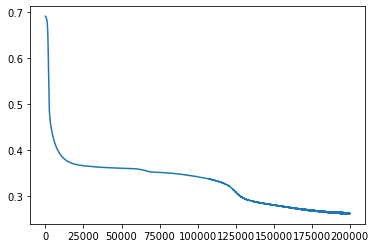

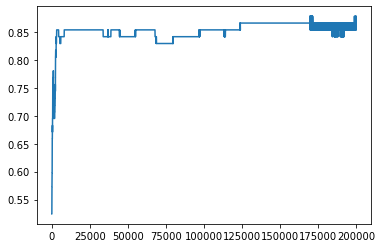

In [16]:
np.seterr(divide = 'print') 

params_values, cost_history, accuracy_history = train(input_array, output_array, nn_architecture, 200001, 0.001, seed=5)

print("Done with the training")

plt.plot(cost_history)
plt.figure()
plt.plot(accuracy_history)

<AxesSubplot:xlabel='x', ylabel='y'>

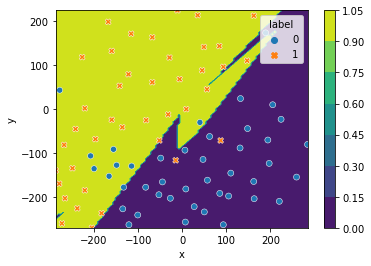

In [17]:
x = np.linspace(df['x'].min(), df['x'].max(), 101)
y = np.linspace(df['y'].min(), df['y'].max(), 101)
xx, yy = np.meshgrid(x,y)
Y_hat, _ = full_forward_propagation(
    np.vstack([xx.flatten(), yy.flatten()]),
    params_values,
    nn_architecture)
predict_class = convert_prob_into_class(Y_hat).reshape((101, 101))

predict_class.shape, x.shape, y.shape
plt.contourf(x, y, predict_class)
plt.axis('scaled')
plt.colorbar()
sns.scatterplot(data=df, x='x', y='y', style='label', hue='label')